In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


# 1. Data Analysis

Firstly, I will try to extract as much information about the dataset as possible.

In [2]:
train = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col=0)
test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col=0)


print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 80)
test:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)
y = train[['SalePrice']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [4]:
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [5]:
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [6]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']   #MSSubClass is nominal
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

I separated numeric features from categorical as I am going to apply different visualization techniques on them

## 1.1 Univariate analysis

### Numeric Features
For numerical features, I am concerned about the distribution of them, including the statistical characteristics of these columns e.g mean, median, mode. Hence I will use Distribution plot to visualize their data distribution.

/tmp/ipykernel_21/308908414.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numeric_.loc[:,column].dropna(), kde=False)


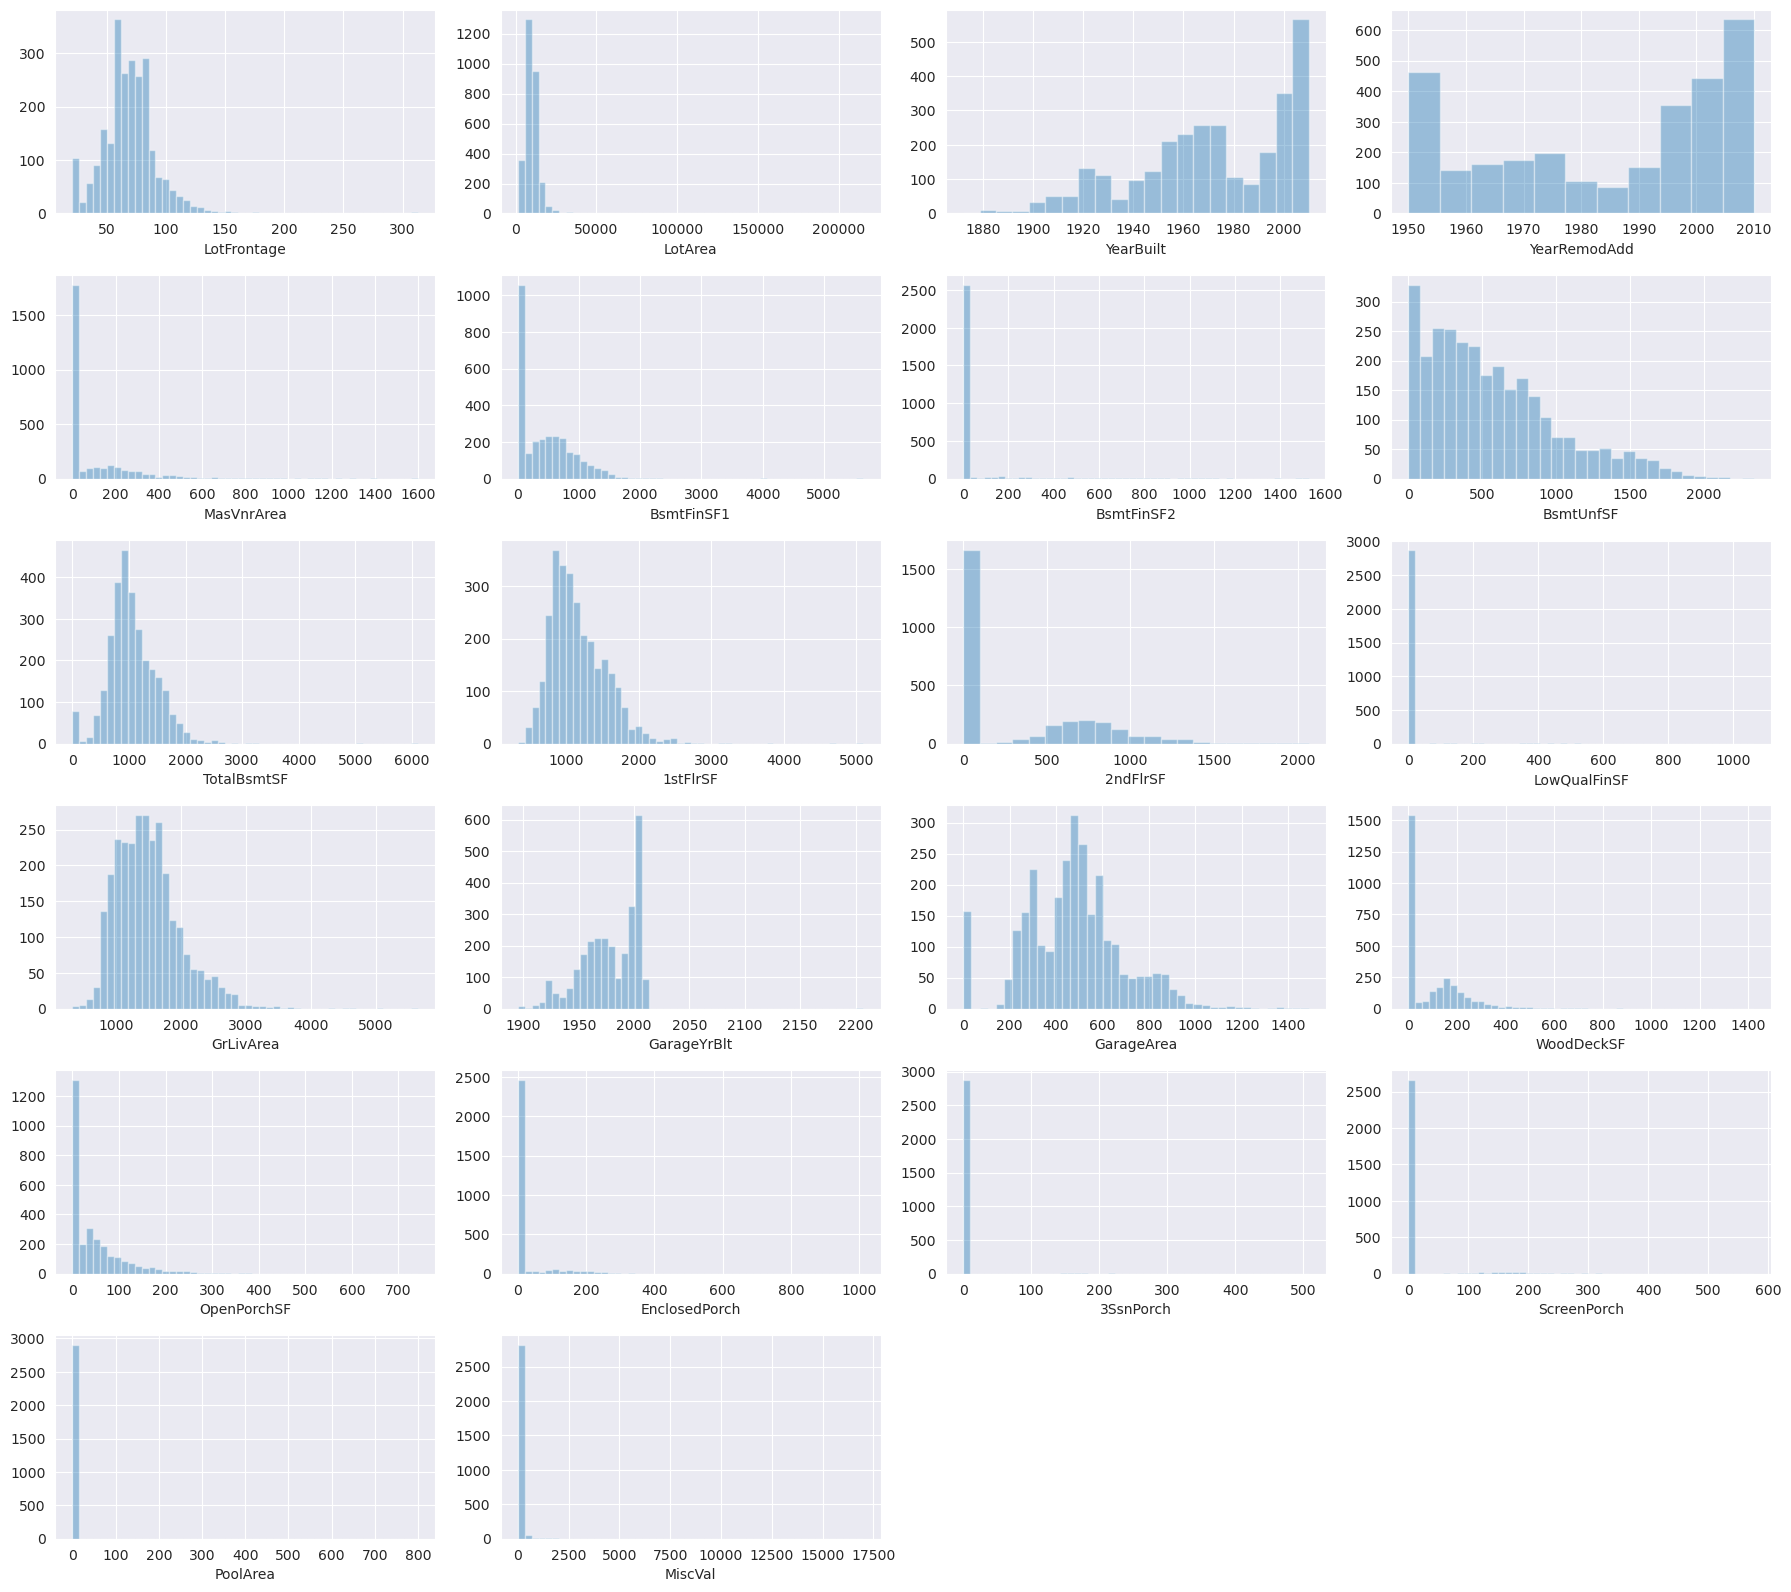

In [7]:
figure = plt.figure(figsize=(18,16))
for index,column in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(numeric_.loc[:,column].dropna(), kde=False)
figure.tight_layout(pad=1.0)

Some of the Variables with mostly 1 value as seen from the plots above:

1. BsmtFinSF2
2. LowQualFinSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch
6. PoolArea
7. MiscVal

All these features are highly skewed, with mostly 0s. Having a lot of 0s in the distribution does not really add information for predicting Housing Price. So, I will remove them during preprocessing step

Let's use boxplots to look for outliers in our data

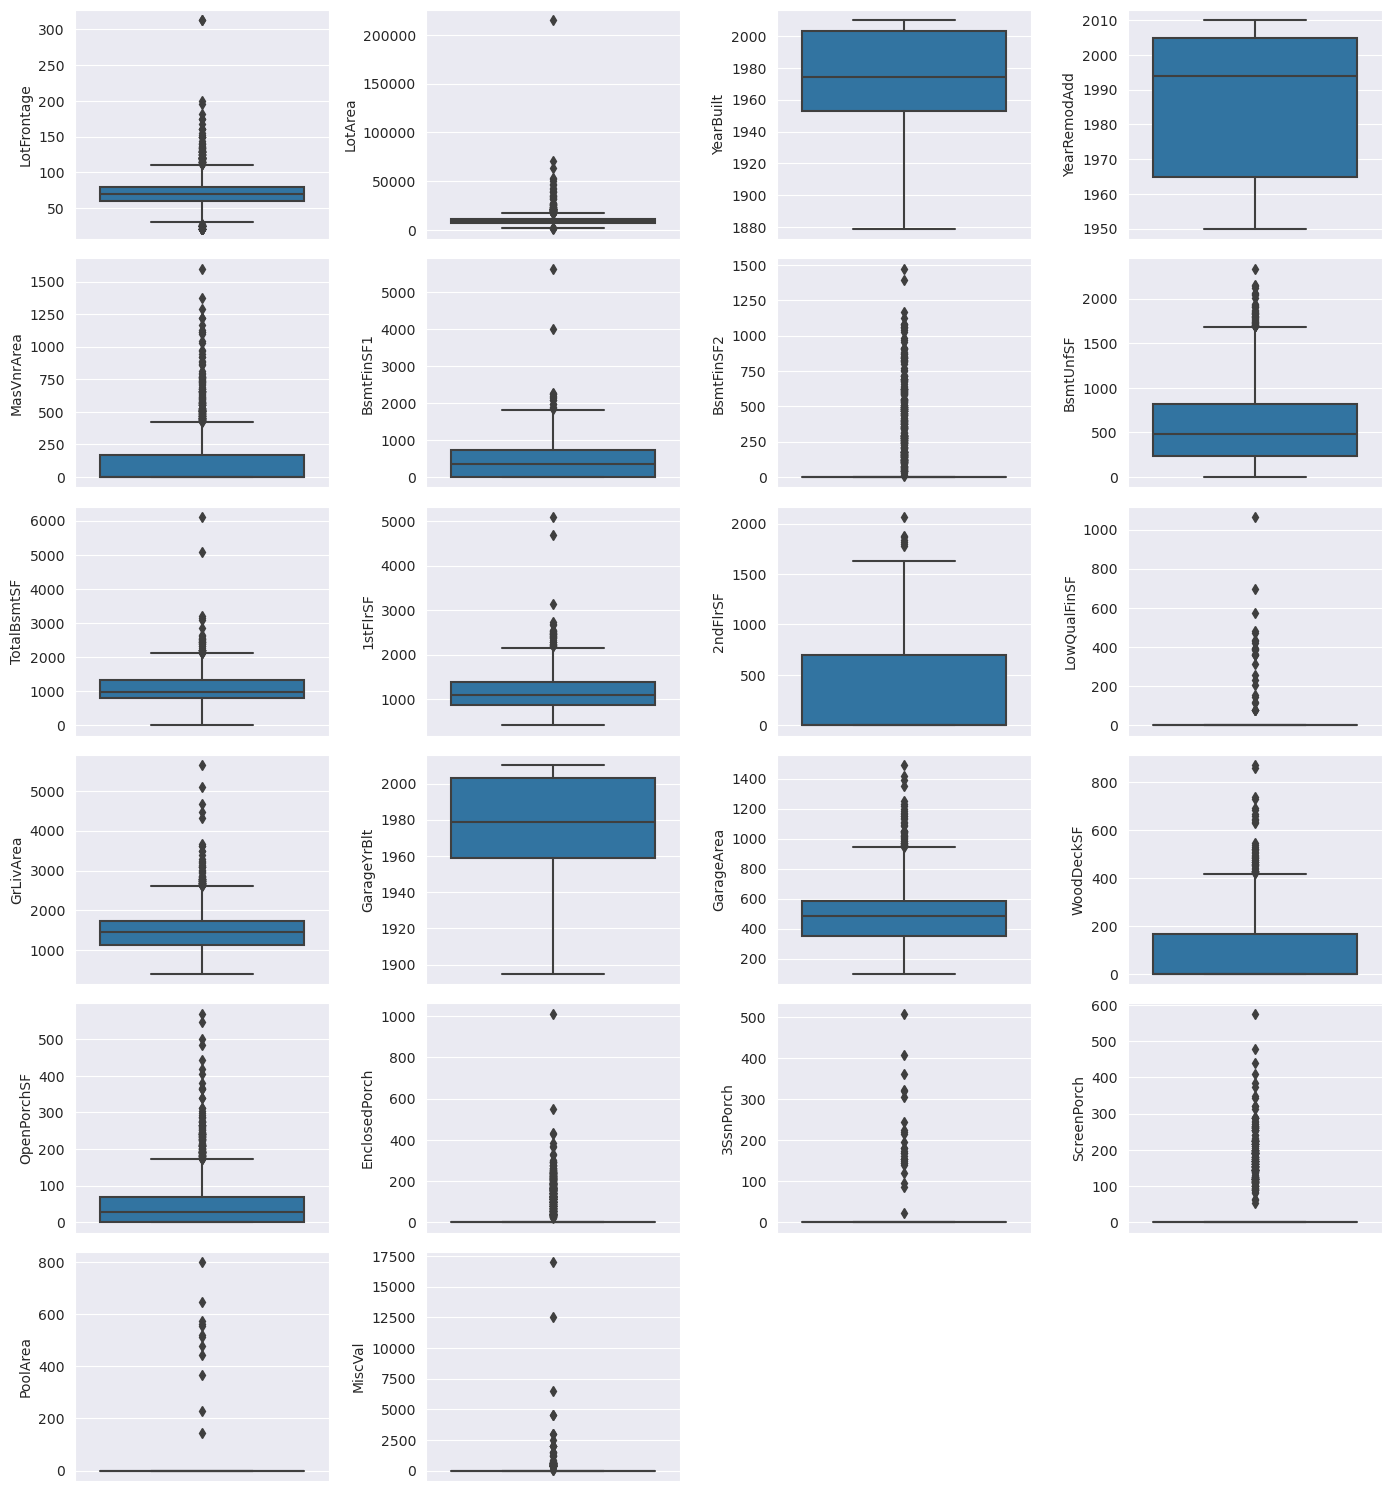

In [8]:
figure = plt.figure(figsize=(14,15))
for index,column in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=column, data=numeric_.dropna())
figure.tight_layout(pad=1.0)

### Categorical Features
In the case of categorical features, I am going to use countplots to visualize the count of each distinct value within each feature. We can see that some categorical features like Utilities, Condition2 consist of mainly just one value, which does not add any useful information. Thus, I will also remove them later on.

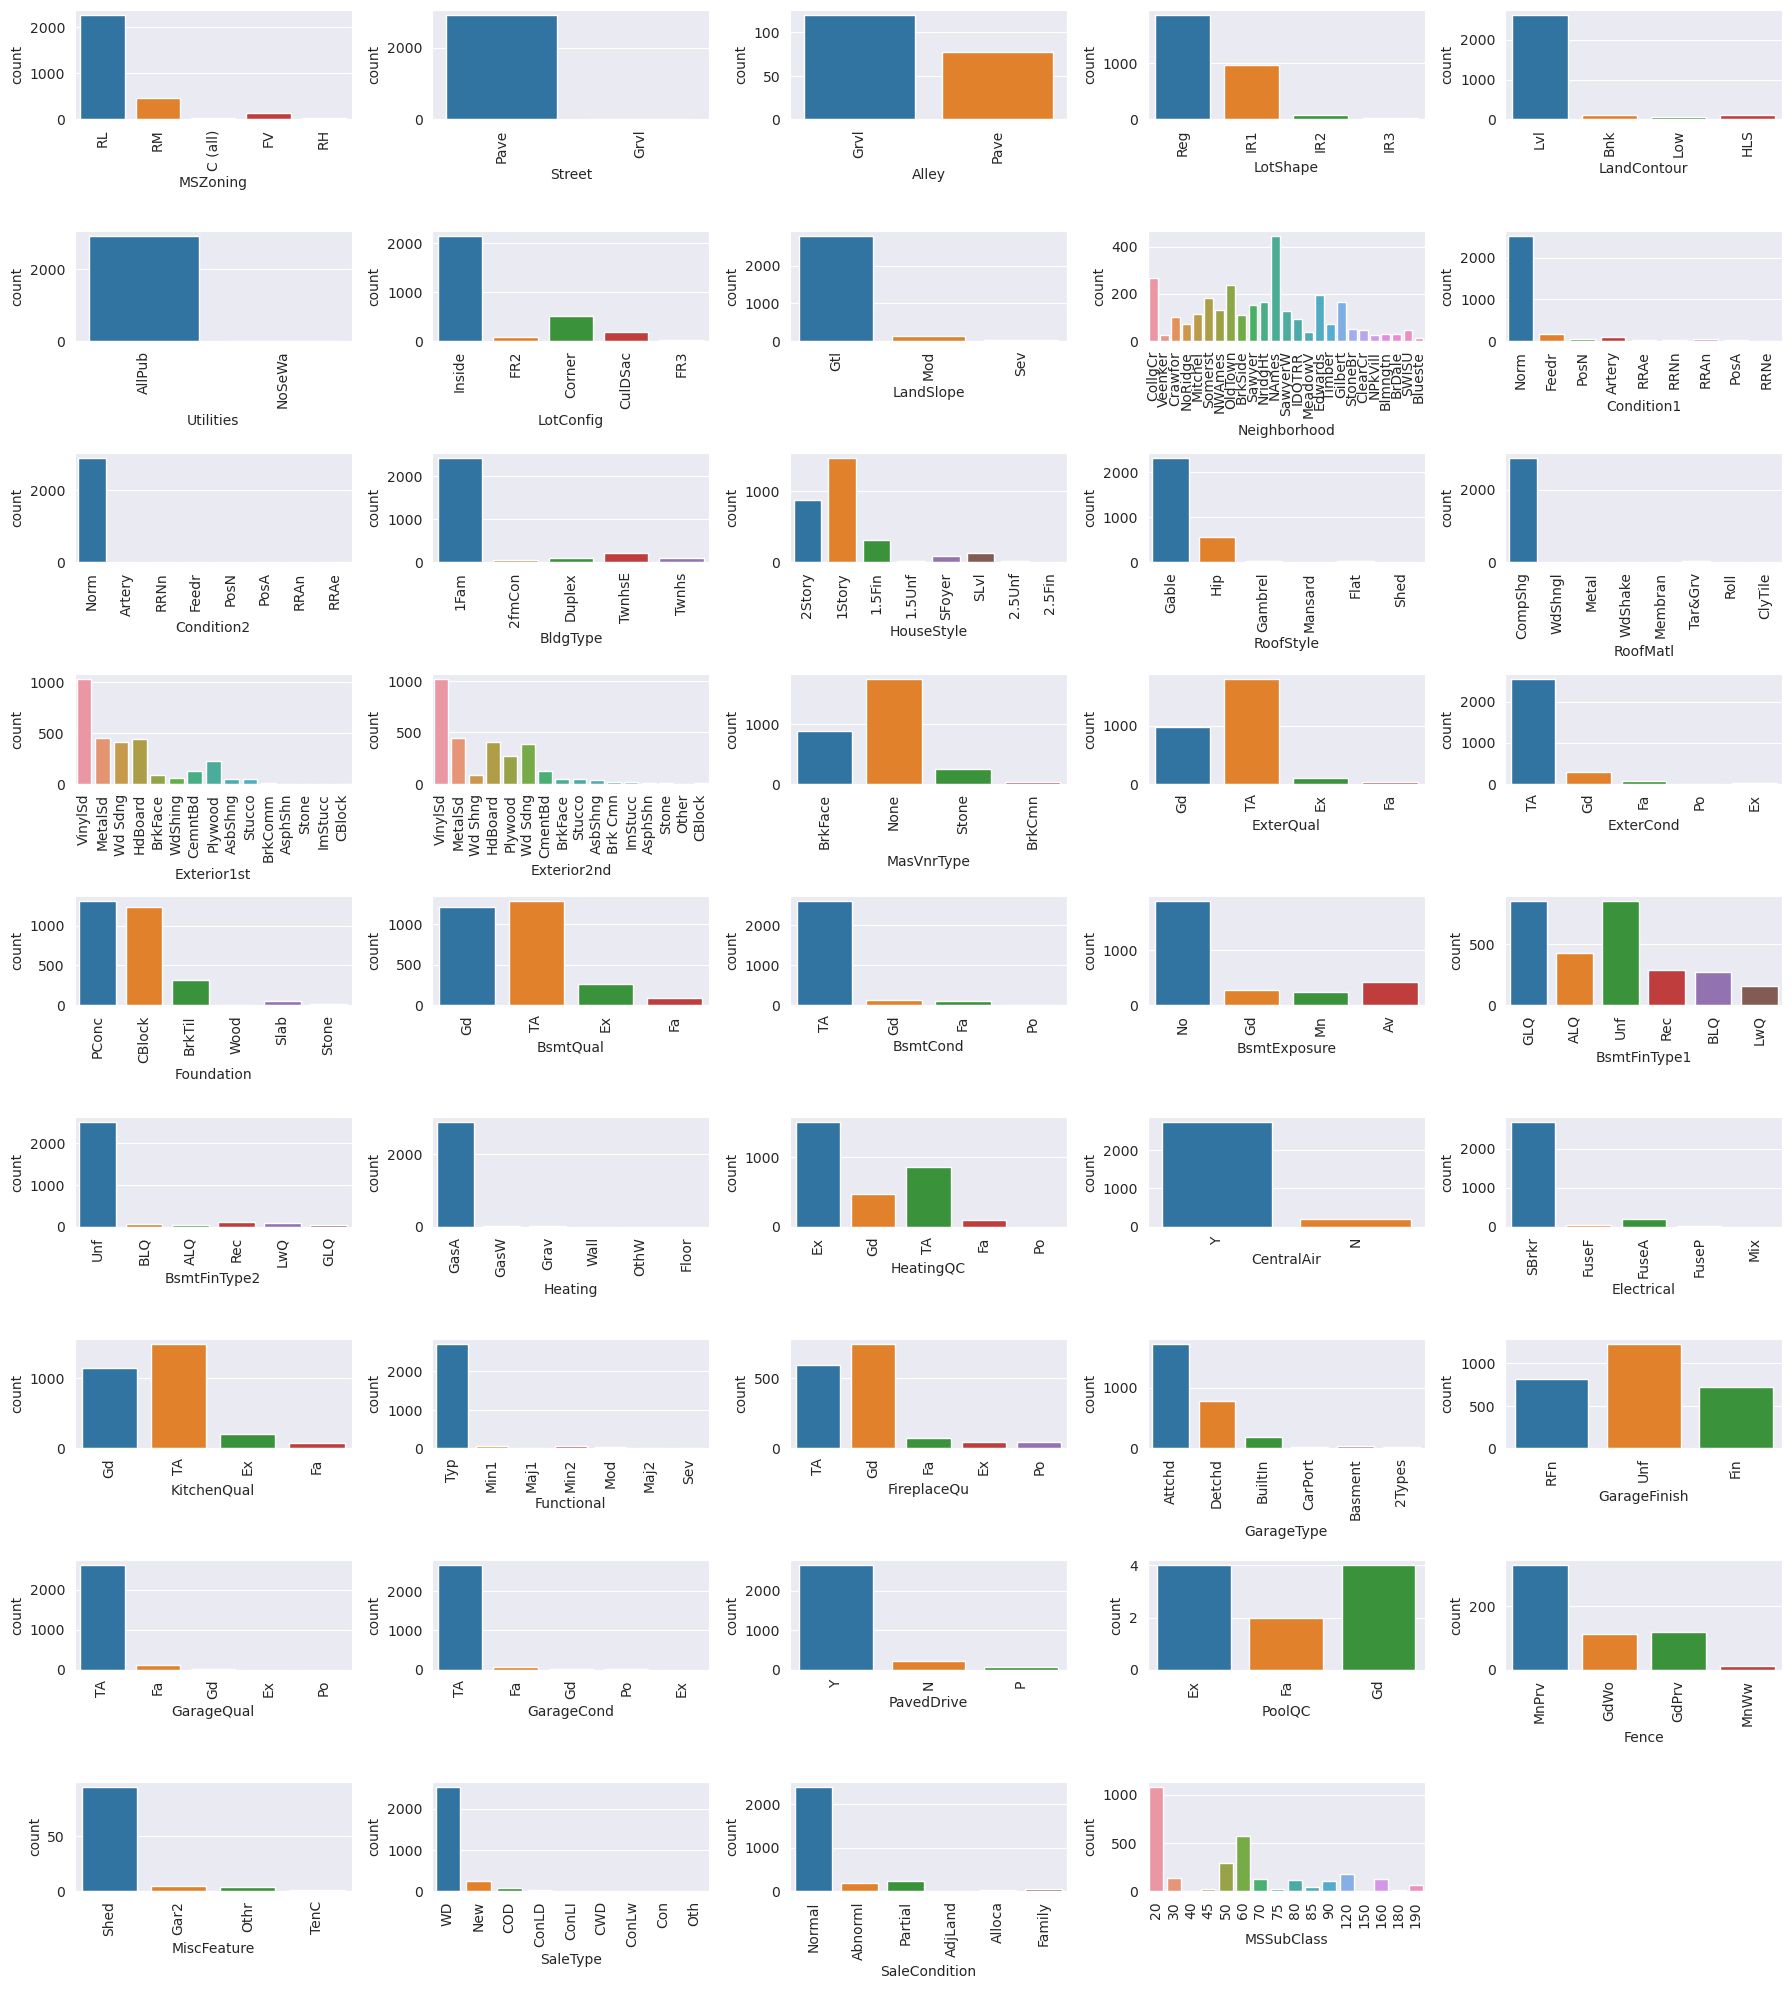

In [9]:
figure = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
figure.tight_layout(pad=1.0)

## 1.2 Bi-Variate Analysis

Bi-variate analysis looks at 2 different features to identify any possible relationship or distinctive patterns between the 2 features. I will make it through the Correlation Matrix.

### Correlation Matrix

<Axes: >

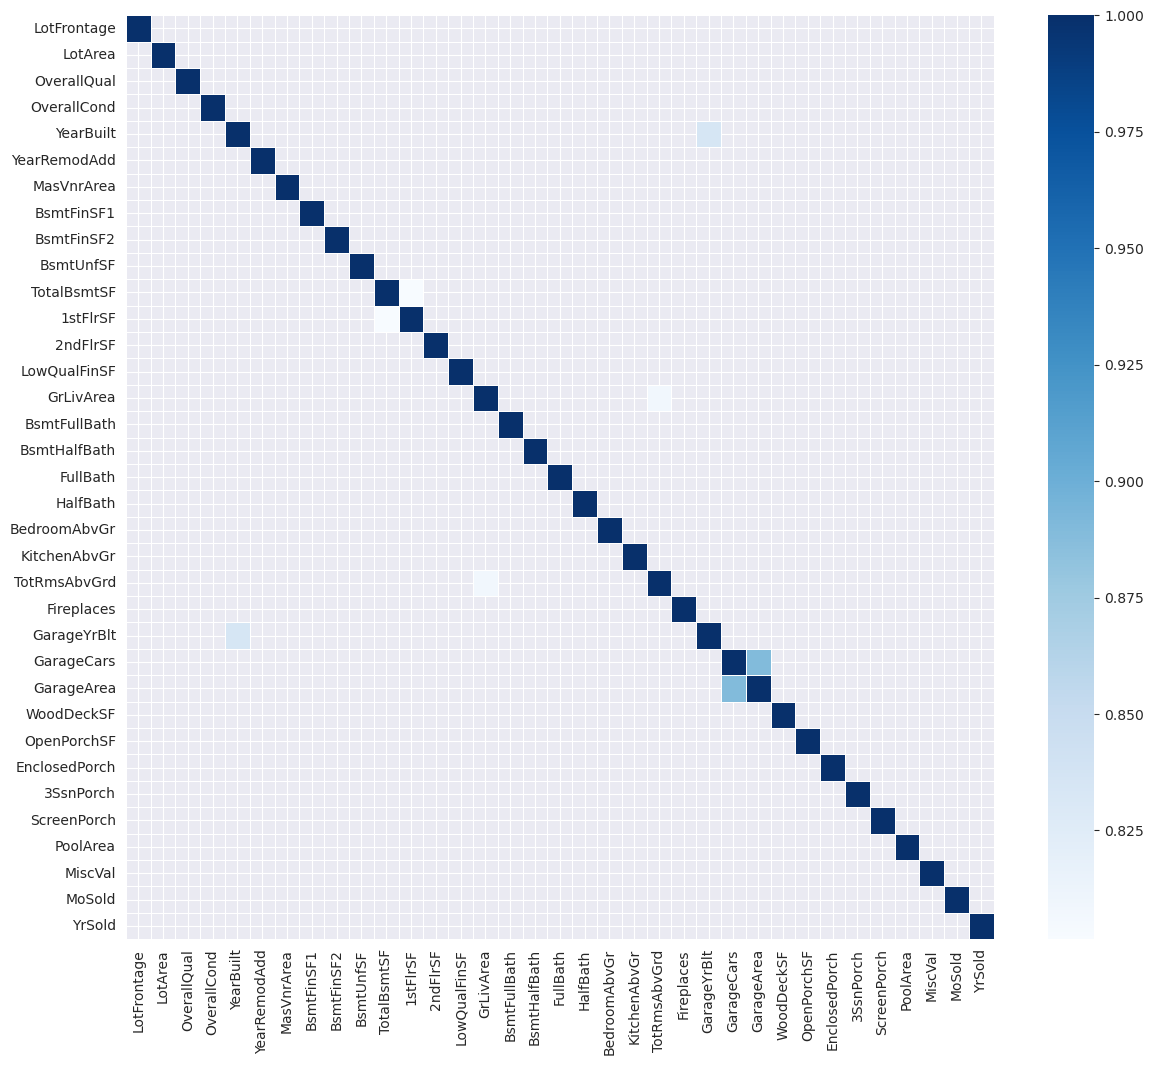

In [10]:
plt.figure(figsize=(14,12))
correlation = numeric_.corr()
sns.heatmap(correlation, mask = correlation < 0.8, linewidth=0.5, cmap='Blues')

**Highly Correlated variables:**

* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

I will have to deal with these features later to avoid performance loss in my model

### Identifying relationship between Numerical Predictor and Target (SalePrice)
Below, I sorted the strength of linear relationship between Saleprice and other features. OverallQual and GrLivArea has the strongest linear relationship with SalePrice. Hence, these 2 features will be important factor in predicting Housing Price

In [11]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Scatter Plot
I am going to use scatterplot to identify potential linear relationship between Numerical features.

/tmp/ipykernel_21/168075373.py:5: UserWarning: The figure layout has changed to tight
  figure.tight_layout(pad=1.0)


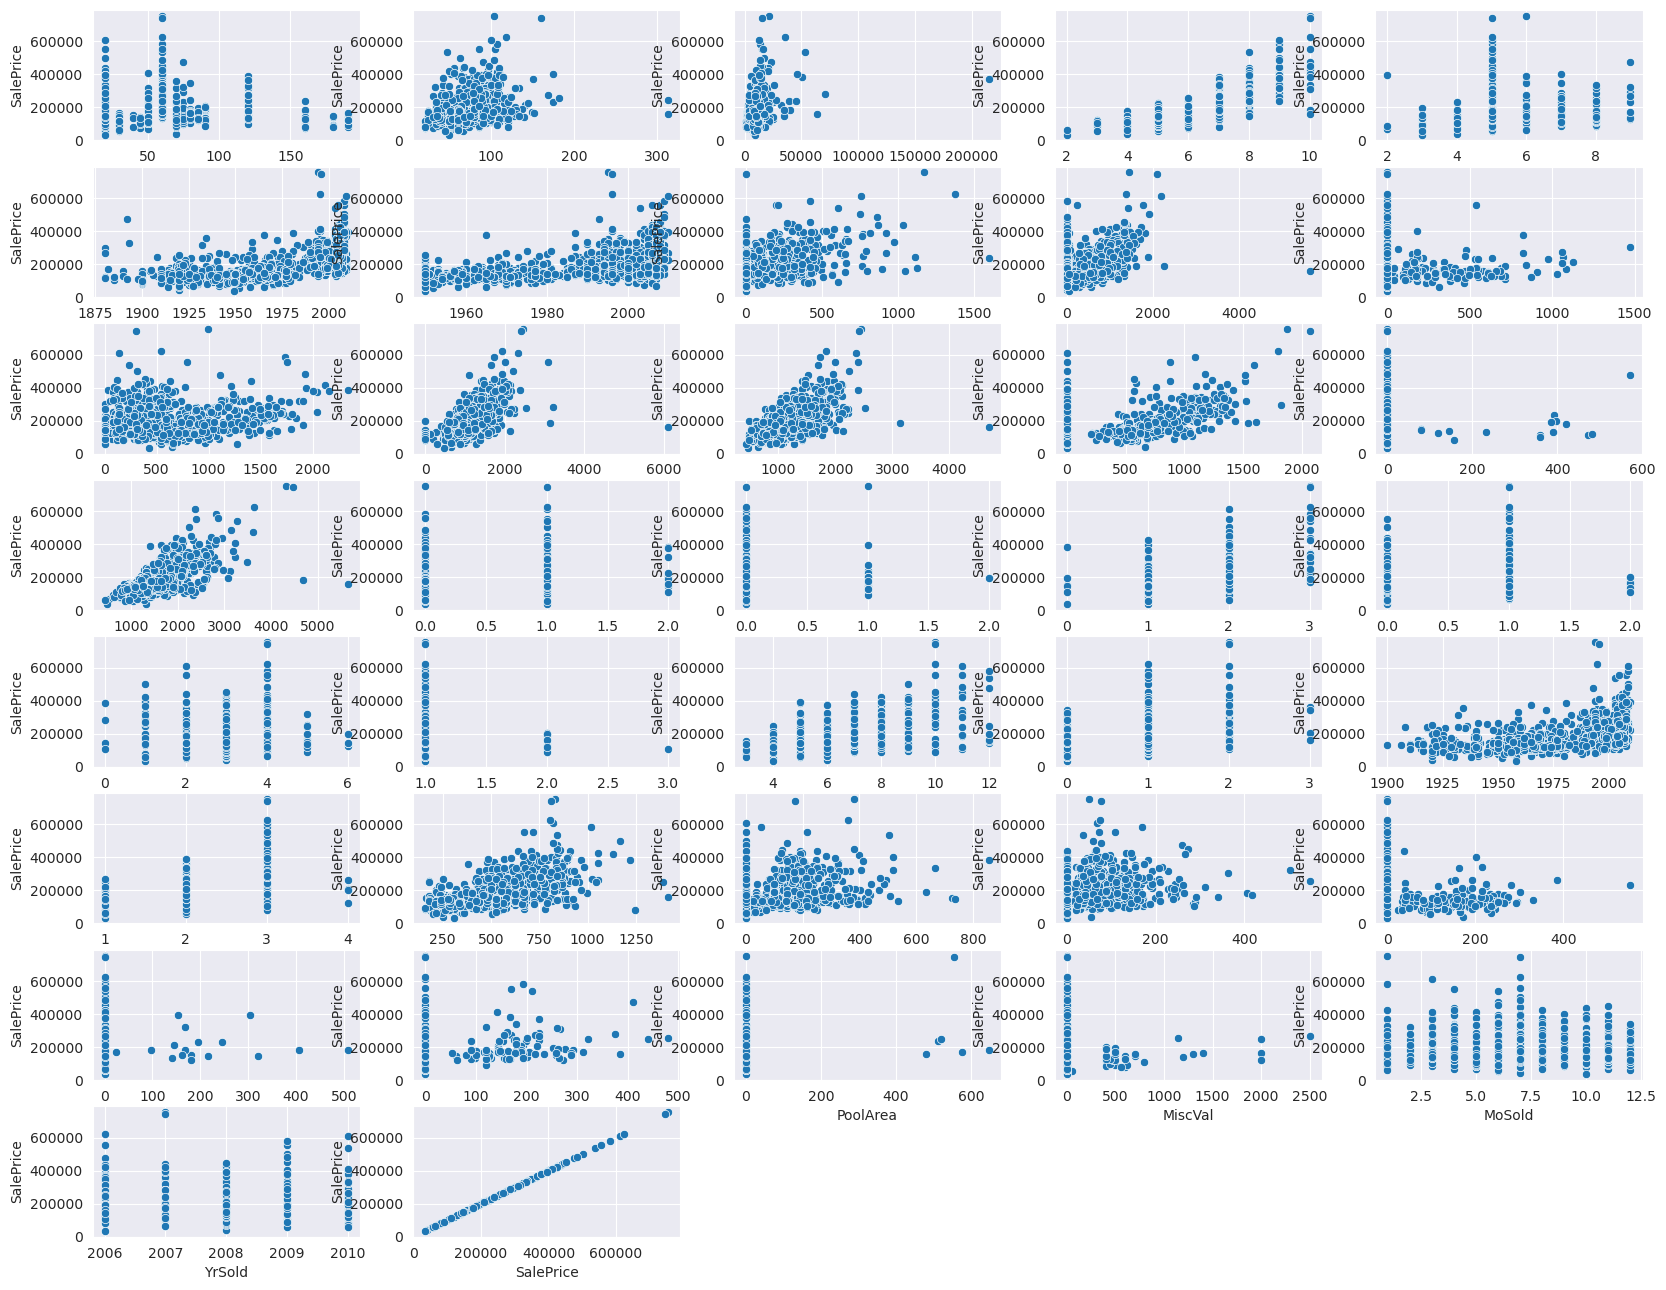

In [12]:
fidure = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train.dropna())
figure.tight_layout(pad=1.0)    

# 2. Data Processing

## 2.1 Removing Redundant Features

### Features with multicollinearity

In [13]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

### Features with alot of missing values

<Axes: title={'center': 'Missing rows number'}, xlabel='features', ylabel='sum'>

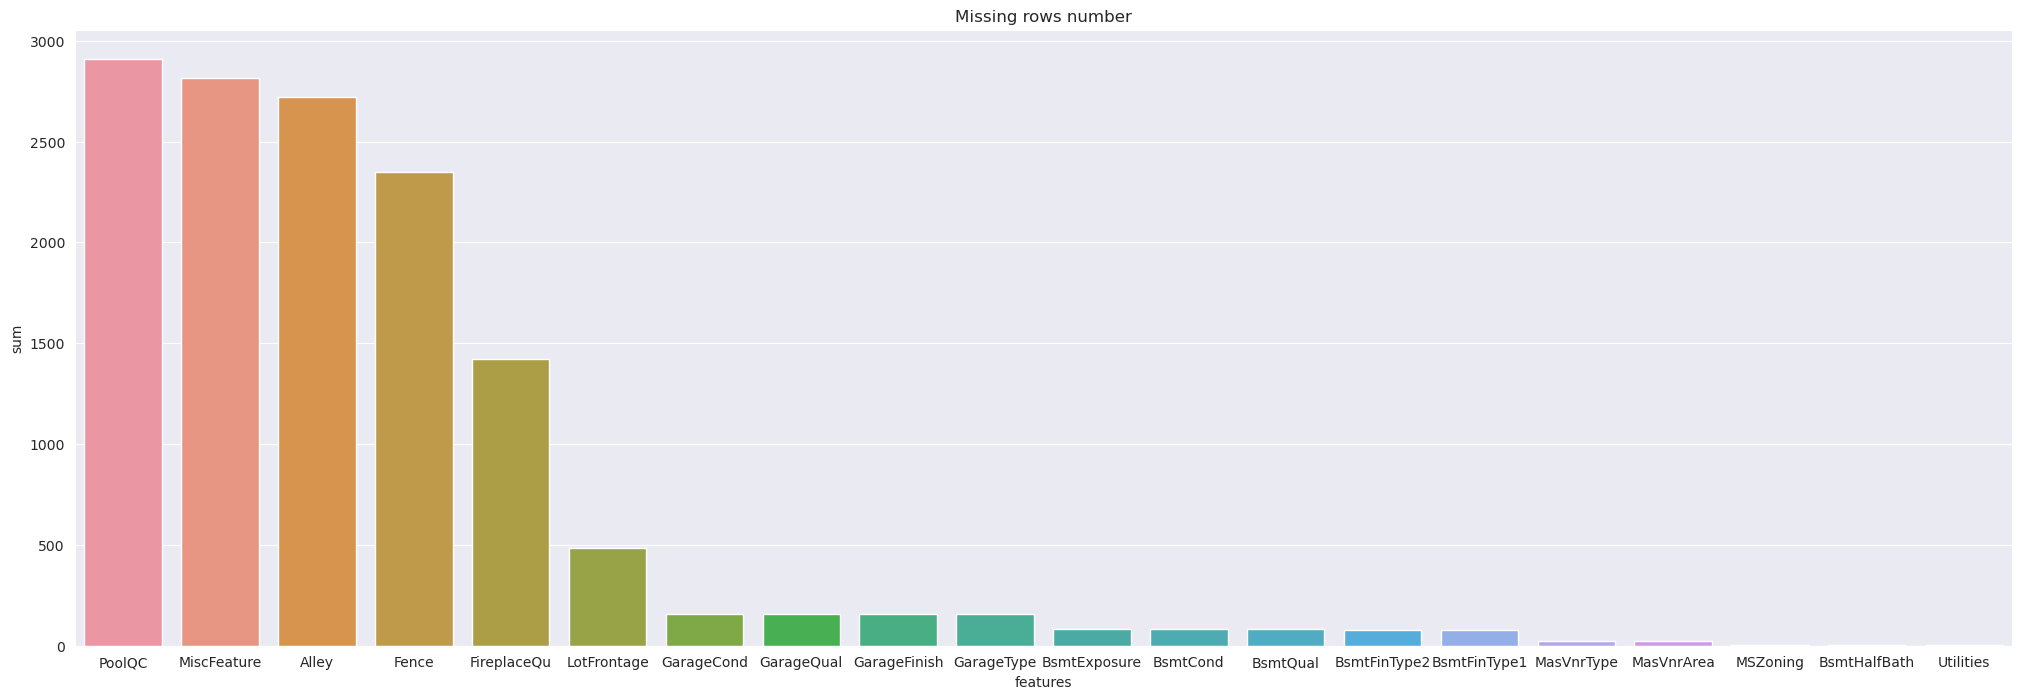

In [14]:
plt.figure(figsize=(25,8))
plt.title('Missing rows number')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features', 'sum']
sns.barplot(x='features', y='sum', data=missing_count)

In [15]:
X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

### Useless features in predicting SalePrice

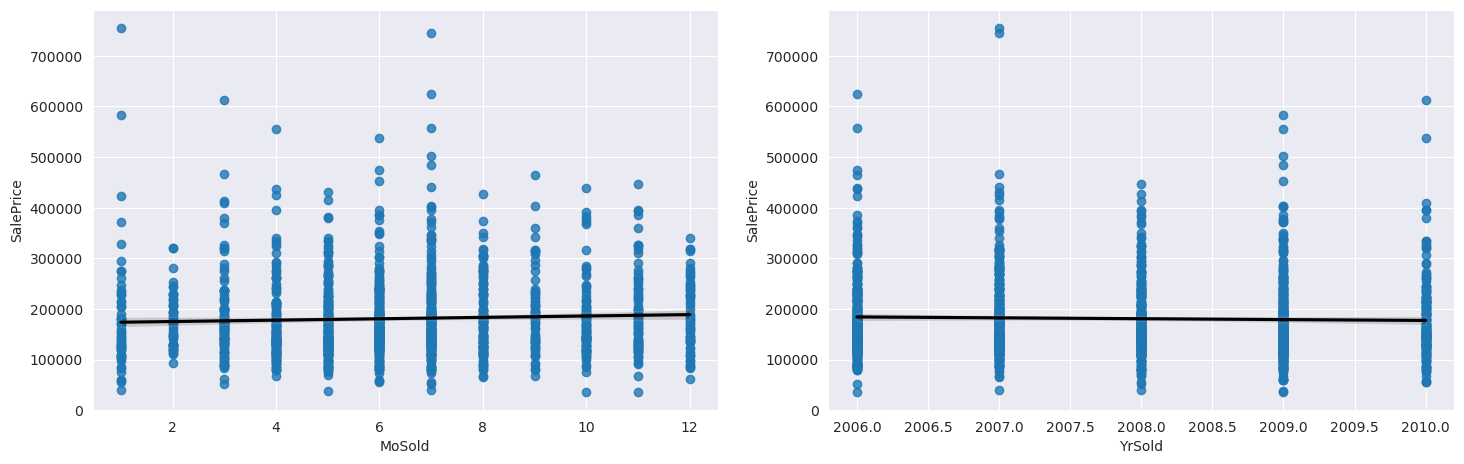

In [16]:
figure, axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax=axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax=axes[1], line_kws={'color':'black'})
figure.tight_layout(pad=2.0)

In [17]:
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False).tail(10)

X.drop(['MoSold','YrSold'], axis=1, inplace=True)

### Removing features that have mostly just 1 value
threshold = 96%

In [18]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

In [19]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

In [20]:
print(f'Categorical Features with >96% of the same value: ',overfit_cat)
print(f'Numerical Features with >96% of the same value: ',overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


## 2.2 Dealing with Outliers
From the boxplot earlier, I have pinpointed the following features with extreme outliers:

* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

I will remove the outliers based on certain threshold value.

In [21]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)
X.shape

(2919, 61)

## 2.3 Filling Missing Values

In [22]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


### Ordinal features

In [23]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")

### Categorical features

In [24]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

### Numerical features

In [25]:
print("Mean of LotFrontage: ", X['LotFrontage'].mean())
print("Mean of GarageArea: ", X['GarageArea'].mean())

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

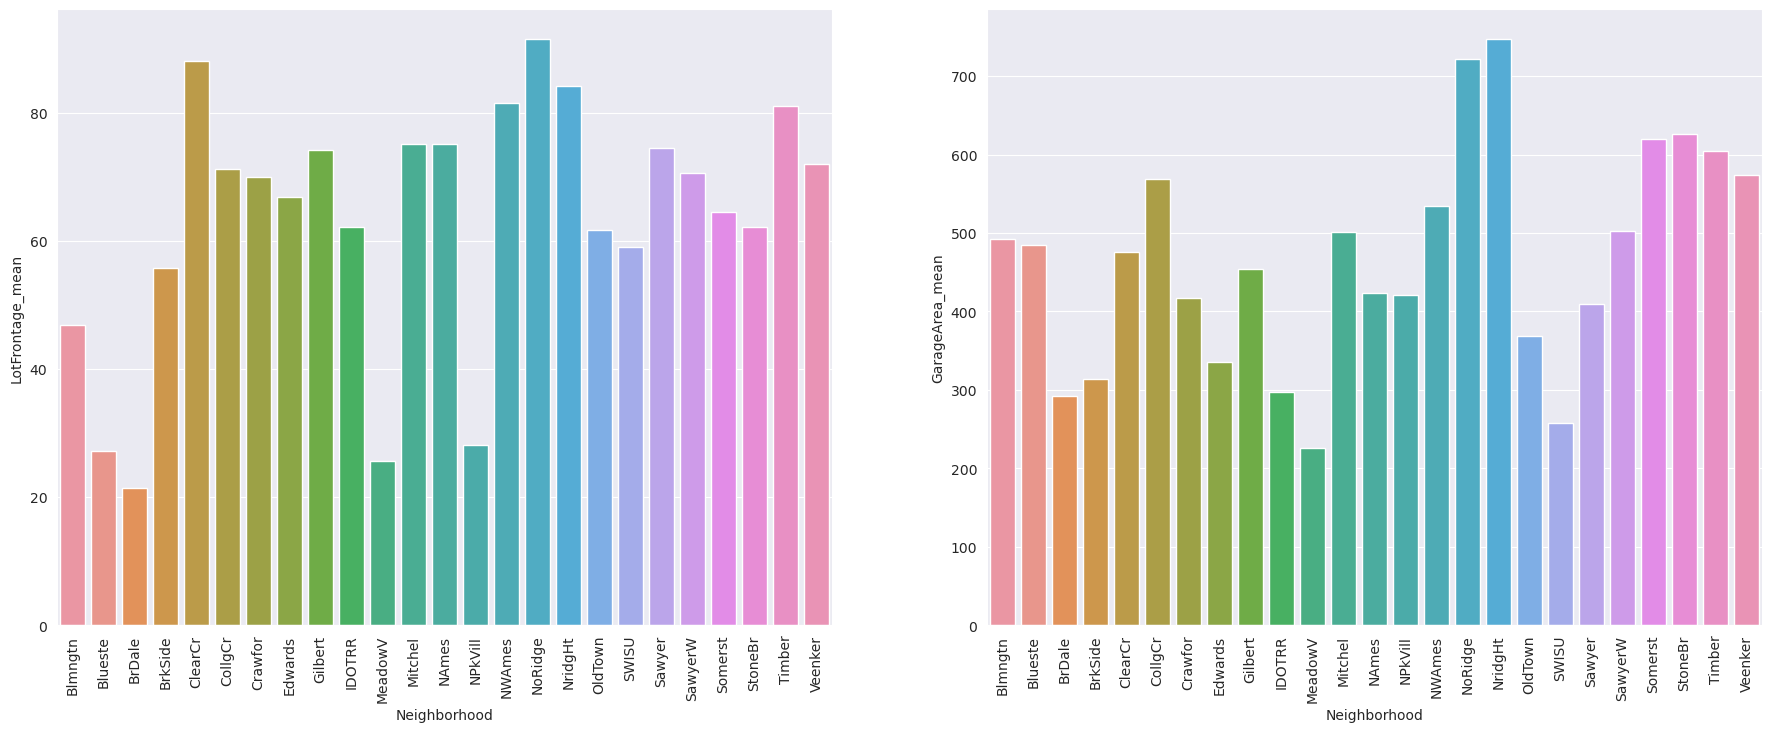

In [26]:
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [27]:
#for correlated relationship
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont] = X[cont].fillna(X[cont].mean())

#### Changing Data Type

In [28]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

### Mapping Ordinal Features

In [29]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [30]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

# 3. Feature Engineering

I am going to create the following features:
    
* TotalLot = LotFrontage + LotArea
* TotalSF = TotalBsmtSF + 2ndFlrSF
* TotalBath = FullBath + HalfBath
* TotalPorch = OpenPorchSF + EnclosedPorch + ScreenPorch
* TotalBsmtFin = BsmtFinSF1 + BsmtFinSF2

In [31]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

### Binary Columns

In [32]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col+'_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)

### Converting Categorical to Numerical

In [33]:
X = pd.get_dummies(X)
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,3,3,4,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,3,3,3,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0


### SalePrice Distribution

/tmp/ipykernel_21/2407697068.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(train['SalePrice'],norm_hist=False)


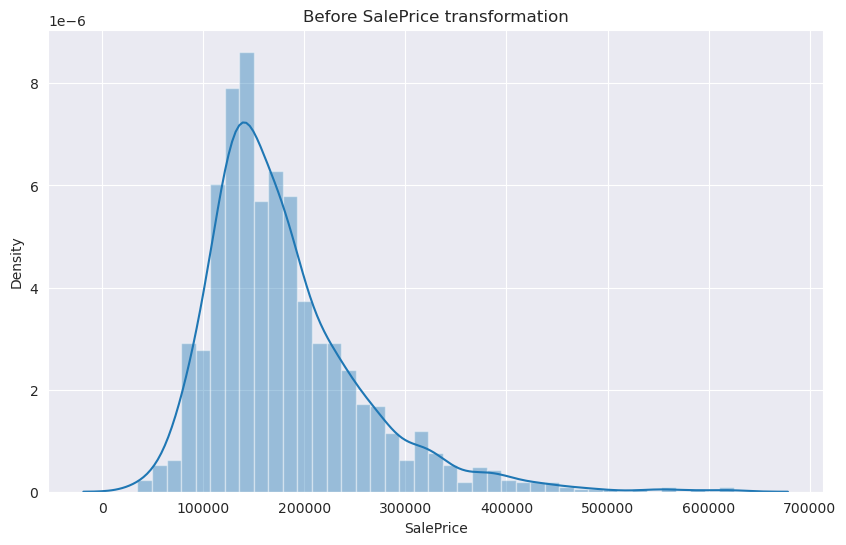

In [34]:
plt.figure(figsize=(10,6))
plt.title("Before SalePrice transformation")
dist = sns.distplot(train['SalePrice'],norm_hist=False)

Distribution is skewed to the right, where the tail on the curve’s right-hand side is longer than the tail on the left-hand side, and the mean is greater than the mode. This situation is also called positive skewness.
Having a skewed target will affect the overall performance of our machine learning model, thus, I will use log transformation on the SalePrice to reduce the skewness of the distribution.

/tmp/ipykernel_21/317145314.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)


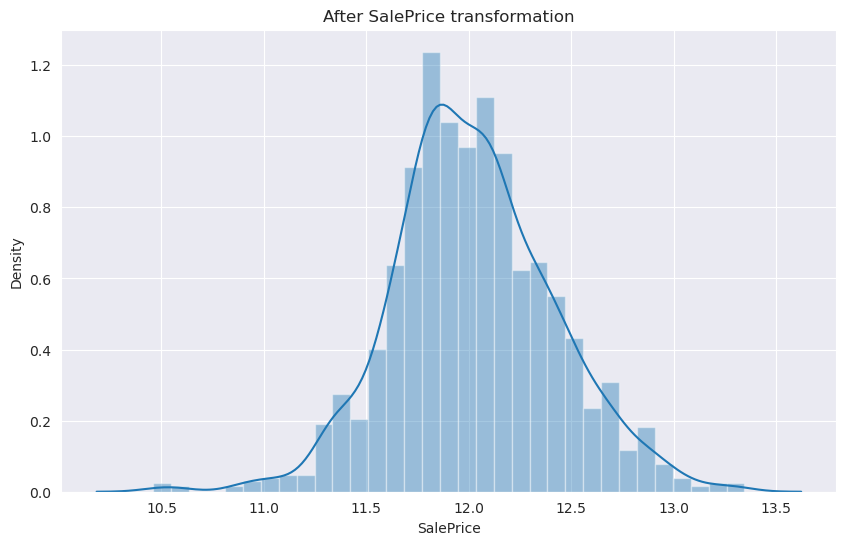

In [35]:
plt.figure(figsize=(10,6))
plt.title("After SalePrice transformation")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [36]:
y["SalePrice"] = np.log(y['SalePrice'])

# 4. Modeling

### Split into train-validation set

In [37]:
x = X.loc[train.index]
y = y.loc[train.index]
test = X.loc[test.index]

## 4.1 Data Scaling

I am going to use RobustScaler

In [38]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2020)

## 4.2 Ensemble Algorithms

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

### XGBoost

In [41]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')
params = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}
xgb_reg = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=100, scoring='neg_root_mean_squared_error', cv=5)
xgb_search = xgb_reg.fit(X_train, y_train)
best_params = xgb_search.best_params_
xgb = XGBRegressor(**best_params)

### LightGBM

In [42]:
lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
                    lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                    n_estimators=100, max_bin=200, min_child_samples=20, 
                    bagging_fraction=0.75, bagging_freq=5,
                    bagging_seed=7, feature_fraction=0.8,
                    feature_fraction_seed=7, verbose=-1)
params = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}
lightgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=params, n_iter=100, scoring='neg_root_mean_squared_error', cv=5)       
lightgbm_search = lightgbm.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: ba

### Catboost

In [43]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
params = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}
catboost = RandomizedSearchCV(estimator=cb, param_distributions=params, n_iter=100, scoring='neg_root_mean_squared_error', cv=5)
catboost_search = catboost.fit(X_train, y_train)
best_params = catboost_search.best_params_
cb = CatBoostRegressor(logging_level='Silent', **best_params)

### Training and Evaluation

In [44]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean


cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, x, y)


xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, x, y)


lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, x, y)

[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

In [45]:
model_performances = pd.DataFrame({
    "Model" : ["XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
      Model  CV(5)    MAE   RMSE  Score
0   XGBoost  0.907  0.077  0.110  0.918
1      LGBM  0.902  0.083  0.115  0.910
2  CatBoost  -543.  0.072  0.103  -557.


### Blending

In [46]:
 def blend_models_predict(X, b, c, d):
        return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

In [47]:
submission = np.exp(blend_models_predict(test, 0.4, 0.3, 0.3))
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': submission})

submission.to_csv("../../kaggle/working/submission.csv", index=False)